In [3]:
import numpy as np
import pybullet as p
import pandas as pd
import time
from robot_descriptions.loaders.pybullet import load_robot_description

pybullet build time: Nov 29 2024 16:26:49


In [4]:
p.connect(p.GUI_SERVER)
sim_timestep = 0.0001
p.setTimeStep(sim_timestep)
p.setGravity(0, 0, -9.81)

Version = 4.1 Metal - 76.3
Vendor = Apple
Renderer = Apple M1
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
b3Printf: PosixSharedMemory::releaseSharedMemory removed shared memory
b3Printf: PosixSharedMemory::releaseSharedMemory detached shared memory

b3Printf: PosixSharedMemory::releaseSharedMemory removed shared memory
b3Printf: PosixSharedMemory::releaseSharedMemory detached shared memory

MotionThreadFunc thread started


In [5]:
robot_id = load_robot_description('ur5_description', useFixedBase=True) 
joint_indices = [i for i in range(p.getNumJoints(robot_id)) if p.getJointInfo(robot_id, i)[2] == p.JOINT_REVOLUTE]
for i in range(p.getNumJoints(robot_id)):
  print(p.getJointInfo(robot_id, i))
  print(p.getJointInfo(robot_id, i)[2] == p.JOINT_REVOLUTE)

wrist3_joint = 6
eff_idx = 7
pendulum_joint_idx = 8
immovable_joints = [pendulum_joint_idx]
print("End effector joint: ", eff_idx)
print("Revolute joints: ", joint_indices)

(0, b'world_joint', 4, -1, -1, 0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, b'base_link', (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0), -1)
False
(1, b'shoulder_pan_joint', 0, 7, 6, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 150.0, 3.15, b'shoulder_link', (0.0, 0.0, 1.0), (0.0, 0.0, 0.089159), (0.0, 0.0, 0.0, 1.0), 0)
True
(2, b'shoulder_lift_joint', 0, 8, 7, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 150.0, 3.15, b'upper_arm_link', (0.0, 1.0, 0.0), (0.0, 0.13585, 0.0), (0.0, -0.7071067811848163, 0.0, 0.7071067811882787), 1)
True
(3, b'elbow_joint', 0, 9, 8, 1, 0.0, 0.0, -3.14159265359, 3.14159265359, 150.0, 3.15, b'forearm_link', (0.0, 1.0, 0.0), (0.0, -0.1197, 0.14499999999999996), (0.0, 0.0, 0.0, 1.0), 2)
True
(4, b'wrist_1_joint', 0, 10, 9, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 28.0, 3.2, b'wrist_1_link', (0.0, 1.0, 0.0), (0.0, 0.0, 0.14225), (0.0, -0.7071067811848163, 0.0, 0.7071067811882787), 3)
True
(5, b'wrist_2_joint', 0, 11, 10, 1, 0.0, 0.0, -0.063598776, 0.063598776, 

# Disable default motor control

In [6]:
for i in joint_indices:
    p.setJointMotorControl2(
        bodyUniqueId=robot_id,
        jointIndex=i,
        controlMode=p.VELOCITY_CONTROL,
        force=0  # Disable motor forces
    )

# Feedback and Stabilization

In [8]:
def pd_control(robot_id, q_desired, v_desired, Kp, Kd):
  joint_states = p.getJointStates(robot_id, joint_indices)
  q_measured = np.array([state[0] for state in joint_states])
  v_measured = np.array([state[1] for state in joint_states])
  position_error = q_desired - q_measured
  velocity_error = v_desired - v_measured
  
  tau = Kp * position_error + Kd * velocity_error
  # add gravity compensation
  tau += np.array(p.calculateInverseDynamics(robot_id, q_measured.tolist(), [0] * len(joint_indices), [0] * len(joint_indices)))
  for i in range(len(joint_indices)):
    if joint_indices[i] in immovable_joints: # ensure pendulum and wrist 3 joint is commanded with zero torque
      tau[i] = 0
  return tau

Kp = 100 * np.ones_like(joint_indices)
Kd = 5 * np.ones_like(joint_indices)

def control_to_desired_configuration(robot_id, q_desired, v_desired=None, max_steps=5000, sleep=None):
  if v_desired is None:
    v_desired = np.zeros_like(q_desired)
  for step in range(max_steps):  # Simulation steps
    torques = pd_control(robot_id, q_desired, v_desired, Kp, Kd).tolist()
    p.setJointMotorControlArray(
      bodyUniqueId=robot_id,
      jointIndices=joint_indices,
      controlMode=p.TORQUE_CONTROL,
      forces=torques
    )
    p.stepSimulation()
    if sleep is not None:
      time.sleep(sleep)
    

# Resetting to balanced pose

In [9]:
rest_pose_balancing = [-np.pi / 18 * x for x in [0, 4, -6, 3, 0, 0]]
def reset_to_balancing_pose(robot_id):
  for i in range(len(joint_indices)): 
    p.resetJointState(robot_id, joint_indices[i], targetValue=rest_pose_balancing[i], targetVelocity=0)
    p.setJointMotorControl2(
          bodyUniqueId=robot_id,
          jointIndex=joint_indices[i],
          controlMode=p.VELOCITY_CONTROL,
          force=0  # Disable motor forces
      )

In [10]:
reset_to_balancing_pose(robot_id)
print(p.getLinkState(robot_id, eff_idx))

((0.7105991188452455, 0.19145000000000004, 0.13497427907824036), (-0.004575044985491314, -0.004575044985513715, 0.7070919805519876, 0.70709198055545), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0), (0.7105991244316101, 0.19144999980926514, 0.13497428596019745), (-0.004575044848024845, -0.004575044848024845, 0.7070919871330261, 0.7070919871330261))


In [11]:
rest_pose_swing = rest_pose_balancing.copy()
rest_pose_swing[-1] = np.pi
def reset_to_swing_pose(robot_id):
  for i in range(len(joint_indices)): 
    p.resetJointState(robot_id, joint_indices[i], targetValue=rest_pose_swing[i], targetVelocity=0)
    p.setJointMotorControl2(
          bodyUniqueId=robot_id,
          jointIndex=joint_indices[i],
          controlMode=p.VELOCITY_CONTROL,
          force=0  # Disable motor forces
      )

## Computing a state-feedback controller according to a discrete-time linear quadratic regulator design

# Moving end-effector along a horizontal line

## Forward movement

In [12]:
# Define the start point and direction of the line
reset_to_balancing_pose(robot_id)
start_point = np.array(p.getLinkState(robot_id, eff_idx)[0])  # [x, y, z] in 3D space
direction_vector = np.array([+0.2, 0, 0])  # Direction along X-axis (horizontal)

In [ ]:
target_positions = start_point + np.linspace(0, 1, num=50)[:, np.newaxis] * direction_vector[np.newaxis, :]
print(target_positions[0], target_positions[-1])
print(p.getJointInfo(robot_id, eff_idx))

time.sleep(1)
for target in target_positions:
  joint_angles = p.calculateInverseKinematics(robot_id,eff_idx,target)
  control_to_desired_configuration(robot_id, joint_angles)
  time.sleep(1 / 1000.)

## Backward movement

In [ ]:
# Define the start point and direction of the line
reset_to_balancing_pose(robot_id)
start_point = np.array(p.getLinkState(robot_id, eff_idx)[0])  # [x, y, z] in 3D space
direction_vector = np.array([-0.3, 0, 0])  # Direction along X-axis (horizontal)
target_positions = start_point + np.linspace(0, 1, num=50)[:, np.newaxis] * direction_vector[np.newaxis, :]
print(target_positions[0], target_positions[-1])
print(p.getJointInfo(robot_id, eff_idx))

time.sleep(1)
for target in target_positions:
  joint_angles = p.calculateInverseKinematics(robot_id,eff_idx,target)
  control_to_desired_configuration(robot_id, joint_angles)
  time.sleep(1 / 1000.)

# Balancing the pendulum

In [13]:
from tqdm import tqdm
from math import fmod

class EnvRealistic:
  axis_vector = np.array([0.1, 0, 0])
  action_space = "Continuous [-1, 1]"
  def __init__(self, TIME_HORIZON=1000, sleep=None,swing=False):
    self.TIME_HORIZON = TIME_HORIZON
    self.sleep=sleep
    self.print_dead = True
    self.swing = swing
    self.reference_zero = 0
    self.reset()

  def rand_action(self):
    return np.random.rand() * 2 - 1

  def convert_3d_coords_to_line_position(self, world_pos):
    return world_pos[0] - self.start_point[0]

  def convert_3d_velo_to_line_velo(self, world_vel):
    return np.dot(EnvRealistic.axis_vector, world_vel)

  def get_state(self):
    (world_pos, _, _, _, _, _, world_velo, _) = p.getLinkState(robot_id, eff_idx, computeLinkVelocity=True)
    x = self.convert_3d_coords_to_line_position(np.array(world_pos))
    x_dot = self.convert_3d_velo_to_line_velo(np.array(world_velo))
    theta = fmod(p.getJointState(robot_id, pendulum_joint_idx)[0] - self.reference_zero, 2 * np.pi)
    if theta > np.pi:
      theta = theta - 2 * np.pi
    elif theta < -np.pi:
      theta = 2 * np.pi + theta
    # print(p.getJointState(robot_id, pendulum_joint_idx)[0], theta)
    theta_dot = p.getJointState(robot_id, pendulum_joint_idx)[1]
    return (x, x_dot, theta, theta_dot)

  def reset(self, randomize_theta_dot=False):
    """ 
    Returns state
    """
    self.timestep = 0
    if self.swing : 
      reset_to_swing_pose(robot_id)
    else:
      reset_to_balancing_pose(robot_id)
    if randomize_theta_dot:
      max_theta_dot = 0.4
      max_theta_deviation = 0.03
      p.resetJointState(robot_id, pendulum_joint_idx, 
      targetValue=rest_pose_balancing[-1] + np.random.rand() * 2 * max_theta_deviation - max_theta_deviation,
      targetVelocity=np.random.rand() * 2 * max_theta_dot - max_theta_dot)
    self.start_point = p.getLinkState(robot_id, eff_idx)[0]
    self.back_point = start_point - 3 * EnvRealistic.axis_vector
    self.front_point = start_point  + 2 * EnvRealistic.axis_vector
    return (0, 0, 0, 0)

  
  def step(self, action):
    """
    Returns tuple (state, dead, truncated)
    """
    if action < -1 or action > 1:
      raise Exception("Action not in range [-1, 1]")
    current_position = p.getLinkState(robot_id, eff_idx)[0]
    target = np.array(current_position) + action * EnvRealistic.axis_vector
      
    joint_angles = p.calculateInverseKinematics(robot_id,eff_idx,target)
    control_to_desired_configuration(robot_id, joint_angles, max_steps=100, sleep=self.sleep)
    (x, x_dot, theta, theta_dot) = self.get_state()
    self.timestep += 1
    dead = False
    truncated = False
    if np.abs(theta) > 0.3 and not self.swing:
      if self.print_dead:
        print(theta, " theta DEAD")
      dead = True
    if self.timestep == self.TIME_HORIZON:
      truncated = True
    return ((x, x_dot, theta, theta_dot), dead, truncated)


def generate_sample_of_system_dynamics_realistic(env, nb_samples):
  samples = []
  s = env.reset(randomize_theta_dot=True)
  for _ in tqdm(range(nb_samples)):
    a = env.rand_action()
    next_s, dead, trunc = env.step(a)
    samples.append({
      'x': s[0], 
      'x_dot': s[1], 
      'theta': s[2], 
      'theta_dot': s[3], 
      'u': a, # mapping inputs to {-1, 1} rather than {0, 1} is important, because otherwise the linear regression needs a non-zero constant to fit well
      'evolution_x': next_s[0], 
      'evolution_x_dot': next_s[1], 
      'evolution_theta': next_s[2],
      'evolution_theta_dot': next_s[3]})
    if dead or trunc:
      s = env.reset(randomize_theta_dot=True)
    else:
      s = next_s
  return pd.DataFrame(samples)

In [24]:
env = EnvRealistic(sleep=0.0001)
env.print_dead = False
samples = generate_sample_of_system_dynamics_realistic(env, 5000)

 13%|█▎        | 663/5000 [06:00<47:22,  1.53it/s]  

In [ ]:
print(samples.describe())

## Fit a Linear regression on the data

In [ ]:
from statsmodels.api import OLS

small_angle_samples = samples
predictors = small_angle_samples[['x', 'x_dot', 'theta', 'theta_dot', 'u']]
outcomes = ['evolution_x_dot', 'evolution_theta_dot', 'evolution_x', 'evolution_theta']
params = {}
for o in outcomes:
  model = OLS(small_angle_samples[o], predictors)
  fit = model.fit()
  print(f"{o} linear model:")
  print(fit.params)
  print(f"Mean squared error of {o} fit", fit.mse_resid)
  params[o] = fit.params.to_numpy()

## Computing a state-feedback controller according to a discrete-time linear quadratic regulator design

In [ ]:
from control import dlqr

dT = 0.0001
A = np.array([
  params['evolution_x'][:4], #x
  params['evolution_x_dot'][:4], #x_dot
  params['evolution_theta'][:4], #theta
  params['evolution_theta_dot'][:4] #theta_dot
])
B = np.array([
  [params['evolution_x'][4]], #x
  [params['evolution_x_dot'][4]], #x_dot
  [params['evolution_theta'][4]], #theta
  [params['evolution_theta_dot'][4]] #theta_dot
])
Q = np.diag([125, 50, 1250, 25])
R = np.diag([1.5])

K, S, E = dlqr(A, B, Q, R)
print(K)

# Trying out the learned policy

In [ ]:
s = env.reset()
time.sleep(1)
while True:
  a = np.clip(np.dot(-K, s), -1, 1)
  print(a)
  s, dead, trunc = env.step(a)
  if dead or trunc:
    print(f"Successfull balancing for {env.timestep} timesteps")
    break

# Doing a demonstration

In [ ]:
import pyautogui
from pynput.mouse import Listener

# Function to map cursor x position to action
def cursor_to_action(x, screen_width, action_min=-1, action_max=1):
    return-(( x / screen_width) * (action_max - action_min) + action_min)

# Initialize environment
env = EnvRealistic(TIME_HORIZON=1000,swing = True)

# Main loop to continuously track the cursor position and control the robot
screen_width, screen_height = pyautogui.size()  # Get screen dimensions

# Global flag to stop the loop when mouse is clicked
stop_loop = False

x_dem = []
theta_dem = []
xdot_dem = []
thetadot_dem = []
action_dem = []

# Listener function to detect mouse click
def on_click(x, y, button, pressed):
    global stop_loop
    if pressed:  # If the mouse button is pressed
        stop_loop = True  # Set the flag to True
# Start the mouse listener in the background
listener = Listener(on_click=on_click)
listener.start()

while not stop_loop :
    # Get the current cursor position
    cursor_x, cursor_y = pyautogui.position()
    
    # Map the cursor's x position to robot action
    action = cursor_to_action(cursor_x, screen_width)
    
    # Step the environment with the new action
    state, dead, truncated = env.step(action)
    x_dem.append(state[0])
    theta_dem.append(state[2])
    xdot_dem.append(state[1])
    thetadot_dem.append(state[3])
    action_dem.append(action)
    #if state[2] > 2* np.pi :
    #    stop_loop = True
    # Optionally, print or log the state or action if needed
    print(f"Cursor X: {cursor_x}, Action: {action}")
    
    # Add a sleep interval to control the loop speed if needed
    time.sleep(0.05)  # Adjust for responsiveness (lower values = faster control)
# Stop the listener once the loop is stopped
listener.stop()

print("Loop stopped by mouse click.")

#plotting the obtained trajectory
import matplotlib.pyplot as plt



#plot theta
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(theta_dem)),theta_dem)
plt.xlabel('action number')
plt.ylabel('theta value')
plt.title('evolution of theta along actions')
# Add a horizontal line at y = 2 * pi
plt.axhline(y=2 * np.pi, color='r', linestyle='--', label=r'$2\pi$')
plt.text(len(theta_dem) * 0.8, 2 * np.pi, r'$2\pi$', color='r', ha='center', va='bottom')
# Add grid to the plot
plt.grid(True)
plt.show()

#plot x
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(x_dem)),x_dem)
plt.xlabel('action number')
plt.ylabel('x value')
plt.title('evolution of x along actions')
# Add grid to the plot
plt.grid(True)
plt.show()

#plot theta dot
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(thetadot_dem)),thetadot_dem)
plt.xlabel('action number')
plt.ylabel('theta dot value')
plt.title('evolution of theta dot along actions')
# Add grid to the plot
plt.grid(True)
plt.show()

#plot x dot
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(xdot_dem)),xdot_dem)
plt.xlabel('action number')
plt.ylabel('x dot value')
plt.title('evolution of x dot along actions')
# Add grid to the plot
plt.grid(True)
plt.show()

#plot actions
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(action_dem)),action_dem)
plt.xlabel('action number')
plt.ylabel('action value')
plt.title('evolution of control value along actions')
# Add grid to the plot
plt.grid(True)
plt.show()


In [ ]:
modify_hist = False #change to True if you want to edit the files (only if taking a new human demo)

In [ ]:
if modify_hist : #to avoid modifying the saved files by accident
    with open('x_dem.txt', 'w') as file:
        for item in x_dem:
            file.write(f"{item}\n")  # Write each item on a new line

    with open('xdot_dem.txt', 'w') as file:
        for item in xdot_dem:
            file.write(f"{item}\n")  # Write each item on a new line

    with open('theta_dem.txt', 'w') as file:
        for item in theta_dem:
            file.write(f"{item}\n")  # Write each item on a new line

    with open('thetadot_dem.txt', 'w') as file:
        for item in thetadot_dem:
            file.write(f"{item}\n")  # Write each item on a new line
    with open('action_dem.txt', 'w') as file:
        for item in action_dem:
            file.write(f"{item}\n")  # Write each item on a new line
    

# Imitate

First load the saved demonstration

In [16]:
# Initialize the lists to store the data from the files
x_dem = []
xdot_dem = []
theta_dem = []
thetadot_dem = []
action_dem = []

# Read data from 'x_dem.txt' and append to x_dem
with open('x_dem.txt', 'r') as file:
    for line in file:
        x_dem.append(float(line.strip()))  # Assuming data is float, change to int if needed

# Read data from 'xdot_dem.txt' and append to xdot_dem
with open('xdot_dem.txt', 'r') as file:
    for line in file:
        xdot_dem.append(float(line.strip()))  # Assuming data is float, change to int if needed

# Read data from 'theta_dem.txt' and append to theta_dem
with open('theta_dem.txt', 'r') as file:
    for line in file:
        theta_dem.append(float(line.strip()))  # Assuming data is float, change to int if needed

# Read data from 'thetadot_dem.txt' and append to thetadot_dem
with open('thetadot_dem.txt', 'r') as file:
    for line in file:
        thetadot_dem.append(float(line.strip()))  # Assuming data is float, change to int if needed

# Read data from 'action_dem.txt' and append to action_dem
with open('action_dem.txt', 'r') as file:
    for line in file:
        action_dem.append(float(line.strip()))  # Assuming data is float, change to int if needed




Display the demonstration

In [17]:
env = EnvRealistic(TIME_HORIZON=1000,swing = True)
time.sleep(2)
for t in range(len(action_dem)):
    state, dead, truncated = env.step(action_dem[t])
    

In [19]:
x_dem =np.array(x_dem)
xdot_dem =np.array(xdot_dem)
theta_dem =np.array(theta_dem)
thetadot_dem =np.array(thetadot_dem)
state_D = np.vstack((x_dem,xdot_dem,theta_dem,thetadot_dem)).T

Now imitate by running an optimization problem as detailed in part 6 of the paper.

In [ ]:
import numpy as np
import time
from scipy.optimize import minimize

best_states =[]
# Initialize environment
env = EnvRealistic(TIME_HORIZON=1000, swing=True)
time.sleep(2)

# Define the system dynamics (no change, just call step with clipping)
def dynamics(u):
    state, _, _ = env.step(np.clip(u, -1, 1))
    time.sleep(0.05)
    return state

# Define the cost function
def cost_function_at_t(u_t, X_d, t):
    """
    Computes the cost for a given control u_t at time t, taking into account previous controls
    and previous states in the trajectory.
    """
    
    # Apply the control u_t and get the new state
    new_state = dynamics(u_t)
    
    # Compute cost: the difference between the target trajectory and the simulated state
    cost = np.sum((new_state - X_d[t+1])**2) + u_t**2  # Include control effort in cost
    return cost

# Hierarchical optimization function
def hierarchical_optimization(X_d, T):
    """
    Solves the optimal control problem in a hierarchical fashion by optimizing
    controls at each timestep t, given previous optimal controls.
    """
    U_optimal = np.zeros(T)  # Control array to store optimal controls

    
    # For each timestep, optimize the control for that timestep
    for t in tqdm(range(T-1)):
        # For this step, we want to minimize the cost for control u_t given previous best controls
        
        # Use a discretized search over the control range [-1, 1] with 100 steps
        u_values = np.linspace(-1, 1, 20)
        
        # Minimize the cost for the current timestep's control
        best_cost = float('inf')
        best_u = None
        
        
        for u_t in u_values:
            if t==0:
                env.reset()
            else : 
                p.restoreState(best_states[-1])
            # Minimize cost for this u_t
            cost = cost_function_at_t(u_t, X_d, t)
            
            # If the cost is better, update the best control
            if cost < best_cost:
                best_cost = cost
                best_u = u_t
                best_state = p.saveState()
        u_neighborhood = np.linspace(np.clip(best_u - 0.1, -1, 1), np.clip(best_u + 0.1, -1, 1), int(0.2 / 0.01) + 1)
        for u_t in u_neighborhood:
            if t==0:
                env.reset()
            else : 
                p.restoreState(best_states[-1])
            # Minimize cost for this u_t
            cost = cost_function_at_t(u_t, X_d, t)
            
            # If the cost is better, update the best control
            if cost < best_cost:
                best_cost = cost
                best_u = u_t
                best_state = p.saveState()
        
        # Store the best control for this timestep
        U_optimal[t] = best_u
        
        # Simulate the system with the best control and save the state for the next iteration
        best_states.append(best_state)
    U_optimal[-1] = U_optimal[-2]
    
    return U_optimal

# Example problem parameters
T = len(action_dem)  # Number of timesteps (for example, 131)
X_d = state_D  # Example demonstration trajectory

# Perform the hierarchical optimization
U_optimal = hierarchical_optimization(X_d, T)

# Resulting optimal controls
print("Optimal controls: ", U_optimal)


Display the obtained imitation

In [20]:
# Load the results to avoid running the optimization again
# Initialize an empty list to store the read items
U_optimal = []

# Open the file in read mode and read the data back
with open('U_optimal.txt', 'r') as file:
    for line in file:
        # Remove the newline character and convert to the appropriate type (assuming float or int)
        U_optimal.append(float(line.strip()))  # Or use int(line.strip()) depending on data type


In [21]:
theta_robot= []
thetadot_robot = []
x_robot= []
xdot_robot=[]
env = EnvRealistic(TIME_HORIZON=1000,swing = True)
time.sleep(2)
for t in range(len(U_optimal)):
    state, dead, truncated = env.step(U_optimal[t])
    theta_robot.append(state[2])
    thetadot_robot.append(state[3])
    x_robot.append(state[0])
    xdot_robot.append(state[1])

In [ ]:
modify_opt = False

In [ ]:
if modify_opt : #to avoid modifying the saved files by accident

    with open('U_optimal.txt', 'w') as file:
        for item in U_optimal:
            file.write(f"{item}\n")  # Write each item on a new line
    

Plot the difference in the trajectories between demonstration and robot imitation

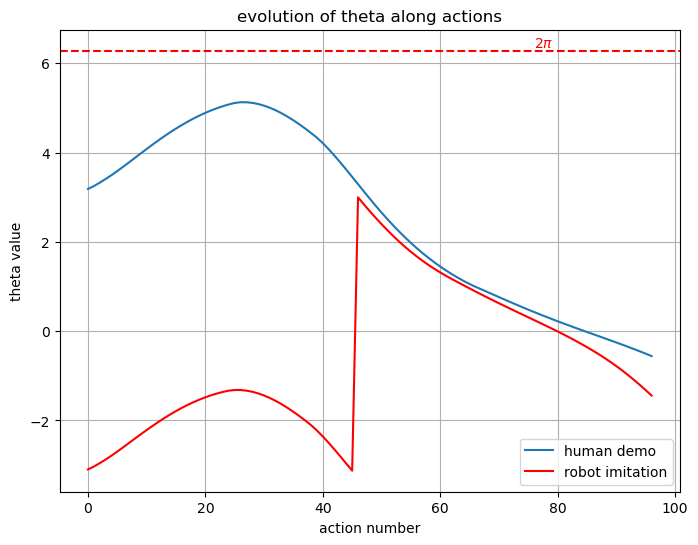

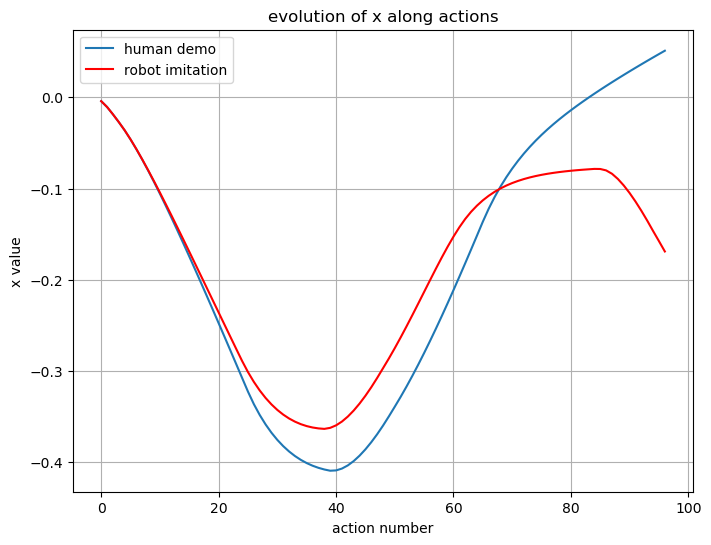

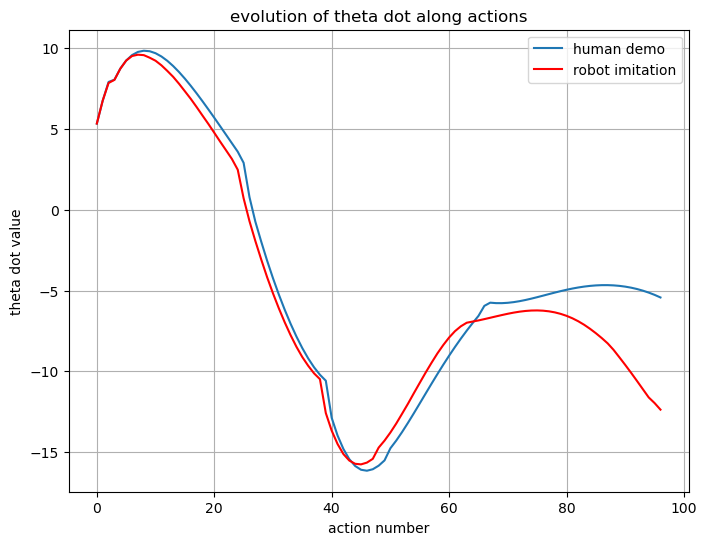

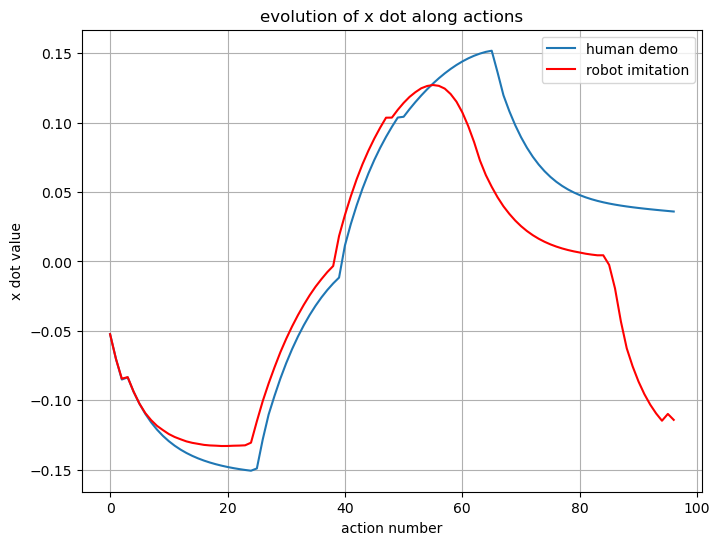

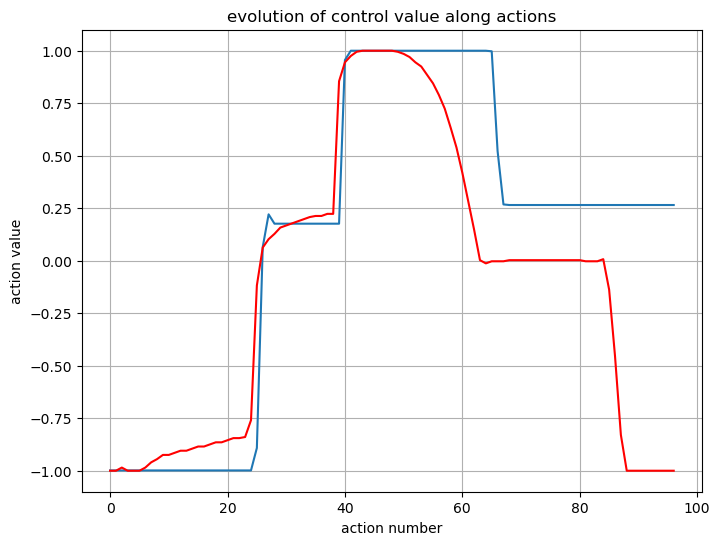

In [22]:
#plot them again
import matplotlib.pyplot as plt



#plot theta
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(theta_dem)),theta_dem,label = 'human demo')
plt.plot(np.arange(len(theta_robot)),theta_robot,label = 'robot imitation', color = 'r')
plt.legend()
plt.xlabel('action number')
plt.ylabel('theta value')
plt.title('evolution of theta along actions')
# Add a horizontal line at y = 2 * pi
plt.axhline(y=2 * np.pi, color='r', linestyle='--', label=r'$2\pi$')
plt.text(len(theta_dem) * 0.8, 2 * np.pi, r'$2\pi$', color='r', ha='center', va='bottom')
# Add grid to the plot
plt.grid(True)
plt.show()

#plot x
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(x_dem)),x_dem,label = 'human demo')
plt.plot(np.arange(len(x_robot)),x_robot,label = 'robot imitation', color = 'r')
plt.legend()
plt.xlabel('action number')
plt.ylabel('x value')
plt.title('evolution of x along actions')
# Add grid to the plot
plt.grid(True)
plt.show()

#plot theta dot
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(thetadot_dem)),thetadot_dem,label = 'human demo')
plt.plot(np.arange(len(thetadot_robot)),thetadot_robot,label = 'robot imitation', color = 'r')
plt.legend()
plt.xlabel('action number')
plt.ylabel('theta dot value')
plt.title('evolution of theta dot along actions')
# Add grid to the plot
plt.grid(True)
plt.show()

#plot x dot
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(xdot_dem)),xdot_dem,label = 'human demo')
plt.plot(np.arange(len(xdot_robot)),xdot_robot,label = 'robot imitation', color = 'r')
plt.legend()
plt.xlabel('action number')
plt.ylabel('x dot value')
plt.title('evolution of x dot along actions')
# Add grid to the plot
plt.grid(True)
plt.show()

#plot actions
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(action_dem)),action_dem)
plt.plot(np.arange(len(U_optimal)),U_optimal,color = 'r')
plt.xlabel('action number')
plt.ylabel('action value')
plt.title('evolution of control value along actions')
# Add grid to the plot
plt.grid(True)
plt.show()

## Read imitations file

In [ ]:
imitation = []
with open("u_opt.txt", "r") as f:
  for line in f.readlines():
    imitation.append(float(line))

## Perform imitation

In [ ]:
reset_to_swing_pose(robot_id)
for a in imitation:
  (x, x_dot, theta, theta_dot), _, _ = env.step(a)

## Hard coded imitation

In [ ]:
hard_coded_imitation = [-0.7] * 30 + [0] * 50 + [0.75] * 30 + [0] * 35 + [-1] * 25 + [0] * 30 + [0.575] * 41 + [0] * 100
reset_to_swing_pose(robot_id)
for a in hard_coded_imitation:
  (x, x_dot, theta, theta_dot), _, _ = env.step(a)


## Perform swing up + balancing

In [23]:
def should_switch_to_balancing(x, x_dot, theta, theta_dot):
  return abs(theta) < 0.5 and abs(theta_dot) < 0.27

reset_to_swing_pose(robot_id)
env.print_dead = False
s = None
for a in U_optimal:
  (x, x_dot, theta, theta_dot), _, _ = env.step(a)
  if should_switch_to_balancing(x, x_dot, theta, theta_dot):
    s = (x, x_dot, theta, theta_dot)
    print(x, x_dot, theta, theta_dot)
    break

env.reference_zero = p.getJointState(robot_id, pendulum_joint_idx)[0]
print(env.reference_zero)
time.sleep(1)
while True:
  a = np.clip(np.dot(-K, s), -1, 1)
  s, dead, trunc = env.step(a)

-1.4421424192526926


NameError: name 'K' is not defined